In [ ]:
from time import time
import cv2
import os, shutil
import seaborn as sns
import keras
import tensorflow
import tensorflow as tf
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from tensorflow.keras.initializers import GlorotUniform

from operator import truediv
from plotly.offline import init_notebook_mode
import random as python_random
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import pandas as pd

In [ ]:
def random_seed_function(seed = 345):
  # Set random seed for numpy
  np.random.seed(seed)
  # Set random seed for python
  python_random.seed(seed)
  # Set random seed for tensorflow
  tf.random.set_seed(seed)
  # Set environment variable for reproducibility
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
## GLOBAL VARIABLES
dataset = 'HT'
test_ratio = 0.7
windowSize = 25

In [ ]:
def loadData(name):
    if name == 'HT':
      data = sio.loadmat('/content/drive/MyDrive/Houston2018/Houston2018_Image.mat')['Image']
      labels = sio.loadmat('/content/drive/MyDrive/Houston2018/Houston2018r_Image_GT.mat')['Image_GT']
    return data, labels

In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    random_seed_function()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
def applyPCA(X, numComponents=75):
    random_seed_function()
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

def padWithZeros(X, margin=2):
    random_seed_function()
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    random_seed_function()
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
X, y = loadData(dataset)

X.shape, y.shape

((200, 200, 48), (200, 200))

In [ ]:
K = X.shape[2]

K = 20 if dataset == 'IP' else 20
X,pca = applyPCA(X,numComponents=K)

X.shape

(200, 200, 20)

In [ ]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((12516, 25, 25, 20), (12516,))

In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3754, 25, 25, 20), (8762, 25, 25, 20), (3754,), (8762,))

# **Model and Training**

In [ ]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
ytrain = np_utils.to_categorical(ytrain)

Xtrain.shape, ytrain.shape

((3754, 25, 25, 20, 1), (3754, 7))

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
ytest = np_utils.to_categorical(ytest)

Xtest.shape, ytest.shape

((8762, 25, 25, 20, 1), (8762, 7))

In [ ]:
S = windowSize
L = K
output_units = 7 if (dataset == 'PU' or dataset == 'PC' or dataset == 'HT') else 16

In [ ]:
class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
        self.conv1 = tf.keras.layers.Conv2D(1, kernel_size, padding="same", use_bias=False)
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    def call(self, x):
        avg_out = tf.reduce_mean(x, axis=4, keepdims=True)
        max_out = tf.reduce_max(x, axis=4, keepdims=True)
        x = tf.concat([avg_out, max_out], axis=4)
        x = self.conv1(x)
        return self.sigmoid(x)

In [ ]:
# input_layer = Input((23, 23, 48, 8))
# out_normal = SpatialAttention()(input_layer)
# out_normal.shape

In [ ]:
class CDCN_3D(tf.keras.layers.Layer):
    def __init__(self,filters, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=False, theta=0.8):
        random_seed_function()
        super(CDCN_3D, self).__init__()
        self.conv = tf.keras.layers.Conv3D(filters=filters, kernel_size=kernel_size, strides=stride, padding='VALID', dilation_rate=dilation, groups=groups, use_bias=bias, activation='relu')
        self.theta = theta

    def call(self, x):
        out_normal = self.conv(x)
        if tf.reduce_all(tf.abs(self.theta - 0.0) < 1e-8):
            return out_normal
        else:
            [C_out, C_in, t, kernel_size, kernel_size] = self.conv.kernel.shape
            if self.conv.kernel.shape[1] >= 1:
                kernel_diff = tf.reduce_sum(self.conv.kernel, axis=[3,4], keepdims=True)
                out_diff = tf.nn.conv3d(input=x, filters=kernel_diff, strides=(1,1,1,1,1),
                                        padding='VALID', dilations=(1,1,1,1,1))
                return out_normal - self.theta * out_diff
            else:
                return out_normal

In [ ]:
# input_layer = Input((25, 25, 20, 1))
# out_normal_1 = CDCN_3D(filters = 1, kernel_size=(3, 3, 7))(input_layer)
# out_normal_1 = SpatialAttention()(out_normal_1) * out_normal_1
# out_normal_1 = CDCN_3D(filters = 1, kernel_size=(3, 3, 7))(out_normal_1)

# out_normal_2 = CDCN_3D(filters = 1, kernel_size=(3, 3, 5))(input_layer)
# out_normal_2 = SpatialAttention()(out_normal_2) * out_normal_2
# out_normal_2 = CDCN_3D(filters = 1, kernel_size=(3, 3, 5))(out_normal_2)

# out_normal_3 = CDCN_3D(filters = 1, kernel_size=(3, 3, 3))(input_layer)
# out_normal_3 = SpatialAttention()(out_normal_3) * out_normal_3
# out_normal_3 = CDCN_3D(filters = 1, kernel_size=(3, 3, 3))(out_normal_3)

# FINAL = tf.concat([out_normal_1, out_normal_2, out_normal_3], axis=3)

# # print(out_normal_1.shape)
# out_normal_1.shape, out_normal_2.shape, out_normal_3.shape, input_layer.shape, FINAL.shape

In [ ]:
random_seed_function()

input_layer = Input((S, S, L, 1))
with tf.device('/gpu:0'):
  out_normal_1 = CDCN_3D(filters = 1, kernel_size=(3, 3, 7))(input_layer)
  out_normal_1 = SpatialAttention()(out_normal_1) * out_normal_1
  out_normal_1 = CDCN_3D(filters = 1, kernel_size=(3, 3, 7))(out_normal_1)

  out_normal_2 = CDCN_3D(filters = 1, kernel_size=(3, 3, 5))(input_layer)
  out_normal_2 = SpatialAttention()(out_normal_2) * out_normal_2
  out_normal_2 = CDCN_3D(filters = 1, kernel_size=(3, 3, 5))(out_normal_2)

  out_normal_3 = CDCN_3D(filters = 1, kernel_size=(3, 3, 3))(input_layer)
  out_normal_3 = SpatialAttention()(out_normal_3) * out_normal_3
  out_normal_3 = CDCN_3D(filters = 1, kernel_size=(3, 3, 3))(out_normal_3)

  FINAL = tf.concat([out_normal_1, out_normal_2, out_normal_3], axis=3)
  flatten_layer = Flatten()(FINAL)

  dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
  dense_layer1 = Dropout(0.4)(dense_layer1)
  dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
  dense_layer2 = Dropout(0.4)(dense_layer2)
  output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

  model = Model(inputs=input_layer, outputs=output_layer)

  adam = Adam(learning_rate=0.001, decay=1e-06)
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

  filepath = "best-model.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
  callbacks_list = [checkpoint]

  history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 0.8828 - accuracy: 0.7666
Epoch 1: accuracy improved from -inf to 0.76665, saving model to best-model.hdf5
15/15 [==============================] - 14s 230ms/step - loss: 0.8828 - accuracy: 0.7666
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 0.6953 - accuracy: 0.8308
Epoch 2: accuracy improved from 0.76665 to 0.83085, saving model to best-model.hdf5
15/15 [==============================] - 3s 227ms/step - loss: 0.6953 - accuracy: 0.8308
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 0.6175 - accuracy: 0.8327
Epoch 3: accuracy improved from 0.83085 to 0.83271, saving model to best-model.hdf5
15/15 [==============================] - 3s 223ms/step - loss: 0.6175 - accuracy: 0.8327
Epoch 4/100
15/15 [==============================] - ETA: 0s - loss: 0.4793 - accuracy: 0.8359
Epoch 4: accuracy improved from 0.83271 to 0.83591, saving model to best-model.hdf5
15/15 [============

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file="CDC_Houston18_25x25x20.pdf", dpi=500, show_shapes=True,show_dtype=True,show_layer_activations=True,show_layer_names=True)

In [ ]:
if os.path.isdir(f"{windowSize}x{windowSize}x{K}_HT"):
  shutil.rmtree(f"{windowSize}x{windowSize}x{K}_HT")
  print(f"Delete {windowSize}x{windowSize}x{K}_HT Folder")
if not os.path.exists(f'{windowSize}x{windowSize}x{K}_HT'):
  os.makedirs(f'{windowSize}x{windowSize}x{K}_HT')
  print(f"Create {windowSize}x{windowSize}x{K}_HT Folder")
else:
  pass

Create 25x25x20_HT Folder


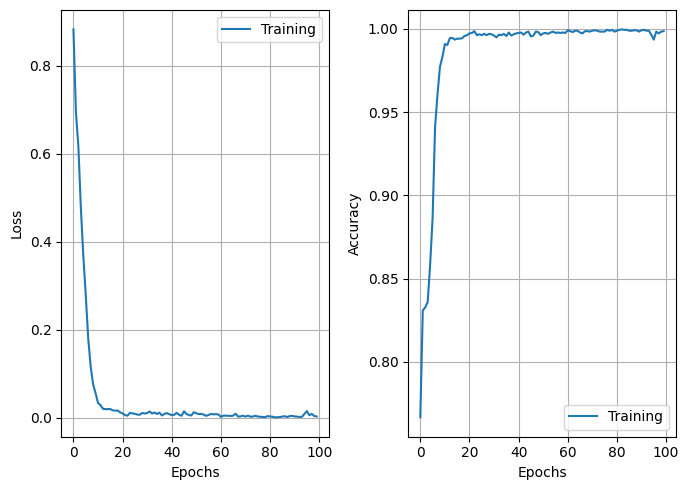

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7, 5))
ax1.grid()
ax1.plot(history.history['loss'])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epochs')
ax1.legend(['Training'], loc='upper right')

ax2.grid()
ax2.plot(history.history['accuracy'])
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epochs')
ax2.legend(['Training'])
plt.tight_layout()
plt.savefig(f"{windowSize}x{windowSize}x{K}_HT/Accuracy_Loss.png")
plt.show()

In [ ]:
data = {
    "Accuracy": history.history['accuracy'],
    "Loss": history.history['loss']
}
data_csv = pd.DataFrame(data)
data_csv.to_csv(f"{windowSize}x{windowSize}x{K}_HT/{S}x{S}x{L}_{dataset}_file.csv", index=False)

In [ ]:
random_seed_function()
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

274/274 [==============================] - 3s 6ms/step


In [ ]:
classification = classification_report(np.argmax(ytest, axis=1), y_pred_test, zero_division=1)
print(classification)

              precision    recall  f1-score   support

           0       0.76      0.62      0.69        72
           1       0.91      0.89      0.90       228
           2       0.98      0.97      0.98       629
           3       1.00      0.00      0.00         9
           5       0.98      1.00      0.99      7295
           6       0.96      0.82      0.89       529

    accuracy                           0.98      8762
   macro avg       0.93      0.72      0.74      8762
weighted avg       0.98      0.98      0.98      8762



In [ ]:
def get_targets(name = None):
    targets_dict = {
        'HT': ['Grass Healhty','Grass Stressed', 'Trees', 'Water', 'Non-Residential Buildings', 'Road']
    }
    targets = targets_dict.get(name)
    return (targets)

target_names_dataset = get_targets("HT")

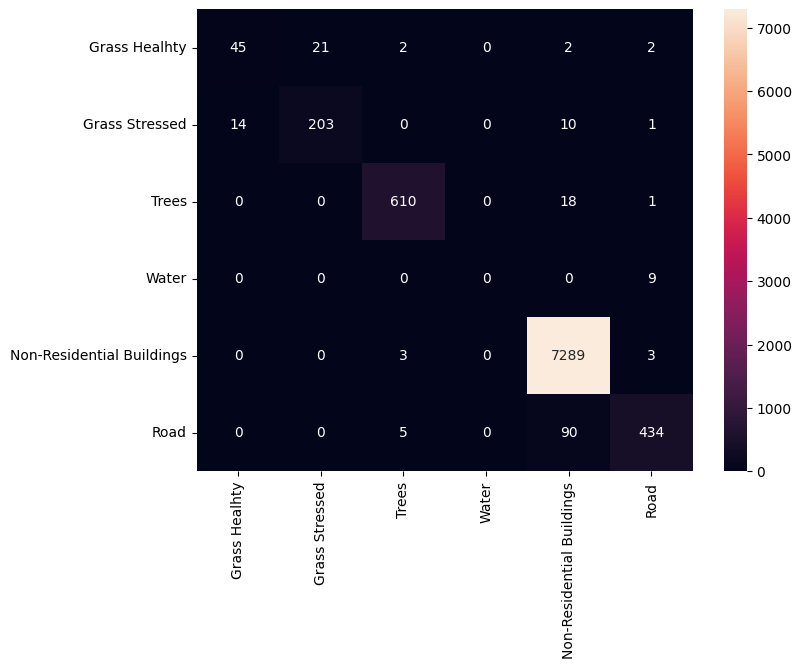

In [ ]:
random_seed_function()
confusion = confusion_matrix(np.argmax(ytest, axis=1), y_pred_test)
cf_matrix = np.asarray(confusion)
plt.figure(figsize=(8,6))
sns_plot=sns.heatmap(cf_matrix, annot=True, xticklabels=target_names_dataset, yticklabels=target_names_dataset, fmt='1d')
plt.savefig(f'{windowSize}x{windowSize}x{K}_HT/CNN_SVM_CF-MATRIX.png', bbox_inches='tight', dpi=300)

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (X_test,y_test, model):
    random_seed_function()
    start = time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    end = time()
    total_time = end - start

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names_dataset, zero_division=1)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100

    return classification, confusion, Test_Loss, Test_accuracy, total_time, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
classification, confusion, Test_loss, Test_accuracy,total_time, oa, each_acc, aa, kappa = reports(Xtest,ytest, model)
classification = str(classification)
confusion = str(confusion)
file_name = f"{windowSize}x{windowSize}x{K}_HT/classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('{} Total Time Sec (%)'.format(total_time))
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

274/274 [==============================] - 4s 9ms/step - loss: 0.1875 - accuracy: 0.9793


In [ ]:
def Patch(data,height_index,width_index,PATCH_SIZE):
    random_seed_function()
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    return patch

In [ ]:
X, y = loadData(dataset)
print("Original X and Y: ", X.shape, y.shape)

height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

X,pca = applyPCA(X, numComponents=numComponents)
print("Before X: ", X.shape)

X = padWithZeros(X, PATCH_SIZE//2)
print("After X: ", X.shape)

Original X and Y:  (200, 200, 48) (200, 200)
Before X:  (200, 200, 20)
After X:  (224, 224, 20)


In [ ]:
random_seed_function()
with tf.device('/gpu:0'):
  outputs = np.zeros((height,width))
  for i in range(height):
    for j in range(width):
      target = int(y[i,j])
      if target == 0 :
        continue
      else :
        image_patch=Patch(X,i,j,PATCH_SIZE)
        X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
        prediction = (model.predict(X_test_image))
        prediction = np.argmax(prediction, axis=1)
        outputs[i][j] = prediction+1

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 213ms/step


In [ ]:
def set_figsize(figsize=(3.5, 2.5)):
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize

def classification_map(map, ground_truth, dpi, save_path):
    fig = plt.figure(frameon=False)
    fig.set_size_inches(ground_truth.shape[1] * 2.0 / dpi, ground_truth.shape[0] * 2.0 / dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.add_axes(ax)
    ax.imshow(map)
    fig.savefig(save_path, dpi=dpi)
    return 0

def list_to_colormap(x_list):
    y = np.ones((x_list.shape[0], 3))
    for index, item in enumerate(x_list):
        if item == 0:
            y[index] = np.array([0, 0, 0]) / 255.
        if item == 1:
            y[index] = np.array([255,0,255])/255.
        if item == 2:
            y[index] = np.array([0,255,0])/255.
        if item == 3:
            y[index] = np.array([0,255,255])/255.
        if item == 4:
            y[index] = np.array([0,150,0])/255.
        if item == 5:
            y[index] = np.array([255,255,0])/255.
        if item == 6:
            y[index] = np.array([190,0,255])/255.
        if item == 7:
            y[index] = np.array([255,0,0])/255.
        if item == 8:
            y[index] = np.array([255,150,0])/255.
        if item == 16:
            y[index] = np.array([190,170,190])/255.
    return y

In [ ]:
ground_truth = y
predicted_data = outputs.astype(int)
ground_truth.shape, predicted_data.shape

((200, 200), (200, 200))

In [ ]:
predicted_data = predicted_data.flatten()
ground_truth = ground_truth.flatten()
ground_truth.shape, predicted_data.shape

((40000,), (40000,))

------Get classification maps successful-------


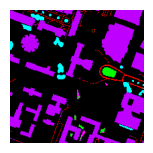

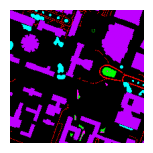

In [ ]:
y_list = list_to_colormap(predicted_data)
y_gt = list_to_colormap(ground_truth)
y_re = np.reshape(y_list, (y.shape[0], y.shape[1], 3))
gt_re = np.reshape(y_gt, (y.shape[0], y.shape[1], 3))
classification_map(y_re, y, 300, f"{windowSize}x{windowSize}x{K}_HT/Prediction_HSI.png")
classification_map(gt_re, y, 300, f"{windowSize}x{windowSize}x{K}_HT/GroundTruth_HSI.png")

print('------Get classification maps successful-------')

Text(0.5, 1.0, 'Ground Truth HSI')

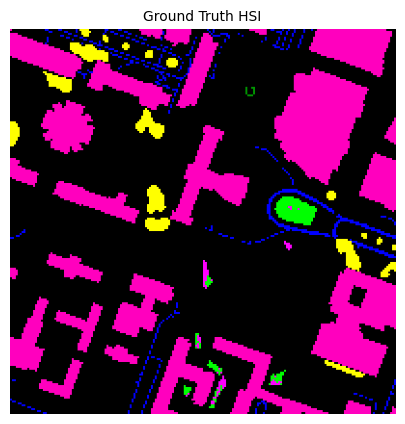

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,1,1)
plt.imshow(cv2.imread(f"{windowSize}x{windowSize}x{K}_HT/GroundTruth_HSI.png"))
plt.axis('off')
plt.title('Ground Truth HSI', fontsize=10)

Text(0.5, 1.0, 'Prediction HSI')

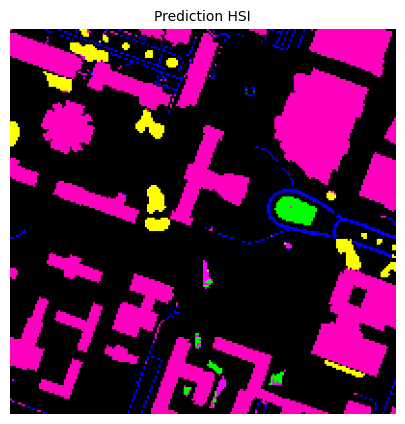

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,1,1)
plt.imshow(cv2.imread(f"{windowSize}x{windowSize}x{K}_HT/Prediction_HSI.png"))
plt.axis('off')
plt.title('Prediction HSI', fontsize=10)